# Classfication Evaluation

In [332]:
import matplotlib.pyplot as plt

In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../modules'))
from CNN_DS_BN_C import CNN_DS_BN_C
from CNN_DS_BN_BC import CNN_DS_BN_BC
from Data_Creator_C import Data_Creator_C

from data_manipulation import *
import tensorflow as tf

In [2]:
red_bls, gains, uvd = load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv','../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')
training_redundant_baselines_dict, testing_redundant_baselines_dict = get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys())
training_baselines_data = get_seps_data(training_redundant_baselines_dict, uvd)
testing_baselines_data = get_seps_data(testing_redundant_baselines_dict, uvd)

## Load in data

In [454]:
data_creator = Data_Creator_C(200,testing_baselines_data,testing_redundant_baselines_dict,gains, evaluation = True)
data_creator.gen_data()
data = data_creator.get_data()

evaluation_inputs = data[0].reshape(-1,1,1024,1)
evaluation_labels = np.asarray(data[1]).reshape(-1,161)
evaluation_targets = np.asarray(data[2]).reshape(-1)
evaluation_seps = data[3]

***

## Evaluate magnitude of delay

In [455]:
network = CNN_DS_BN_C('CNN_DS_BN_C_cm_evaluation', 2, 161)
network.load_params('logs/CNN_DS_BN_C_night2/params/CNN_DS_BN_C')
network.create_graph()

saver = tf.train.Saver()
with tf.Session() as session:

    saver.restore(session,'logs/CNN_DS_BN_C_night2/trained_model.ckpt-800')

    eval_feed_dict = {network.X: evaluation_inputs,
                      network.labels: evaluation_labels,
                      network.sample_keep_prob : 1.,
                      network.downsample_keep_prob : 1.,
                      network.is_training : False}

    predicted_labels = session.run([network.predictions], feed_dict = eval_feed_dict)

creating network graph .... ...... doneINFO:tensorflow:Restoring parameters from logs/CNN_DS_BN_C_night2/trained_model.ckpt-800


***
## Evaluate sign of delay

In [456]:
network_pos_neg = CNN_DS_BN_BC('positive_negative_classifier_cm_evaluation', 2)
network_pos_neg.load_params('logs/positive_negative_classifier_cm_extended/params/CNN_DS_BN_BC')

network_pos_neg.create_graph()
saver_pos_neg = tf.train.Saver()
with tf.Session() as session_pos_neg:

    saver_pos_neg.restore(session_pos_neg,'logs/positive_negative_classifier_cm_extended/trained_model.ckpt-1000')
    
    labels_pos_neg = [[1,0] if d >=0 else [0,1] for d in evaluation_targets]

    eval_feed_dict_pos_neg = {network_pos_neg.X: evaluation_inputs,
                              network_pos_neg.labels: np.asarray(labels_pos_neg).reshape(-1,2),
                              network_pos_neg.sample_keep_prob : 1.,
                              network_pos_neg.downsample_keep_prob : 1.,
                              network_pos_neg.is_training : False}

    predicted_labels_pos_neg = session_pos_neg.run([network_pos_neg.predictions], feed_dict = eval_feed_dict_pos_neg)

creating network graph .... ...... doneINFO:tensorflow:Restoring parameters from logs/positive_negative_classifier_cm_extended/trained_model.ckpt-1000


In [457]:
# the possible classes for this precision
classes = np.arange(0,0.04 + 0.00025, 0.00025)

### make a dictionary of : 
 {true_delay, top_guesses, probabilites_for_each_guess, {sign_of_guess : probability_of_sign}}

In [553]:
top_num = 3
evaluations = []
# predicted_label_top_picks =  []

for i, a in enumerate(np.array(predicted_labels).reshape(-1,161)):
    
    ind = np.argpartition(a, -top_num)[-top_num:]
    
    picks = []
    percs = []
    for j in ind:
        
        picks.append(classes[j])#np.round(classes[j],5))
        percs.append(np.round(a[j],5))
        
    idx = np.argsort(percs)
    sPerc = predicted_labels_pos_neg[0][i]
    s = {"pos" : np.round(np.max(sPerc),4)} if np.argmax(sPerc) == 0 else {"neg" : np.round(np.max(sPerc),4)}
    
#     predicted_label_top_picks.append((np.round(evaluation_targets[i],6), np.array(picks)[idx][::-1], np.array(percs)[idx][::-1], s))
    
    evaluation = {}
    evaluation['true'] = evaluation_targets[i]#np.round(evaluation_targets[i],6)
    evaluation['top_3'] = [x for x in np.array(picks)[idx][::-1]]
    evaluation['top_3_probs'] = [x for x in np.array(percs)[idx][::-1]]
    evaluation['sign'] = s
    evaluation['guess'] = evaluation['top_3'][0] if s.keys()[0] == 'pos' else -1*evaluation['top_3'][0]
    evaluation['error'] = evaluation['true'] - evaluation['guess']

    evaluations.append(evaluation)
                                      

### Print some to take a look

In [554]:
from pprint import pprint as pPrint

In [555]:
for x in evaluations[10:13]:
    pPrint(x)
    print('\n')

{'error': -2.788380328183626e-05,
 'guess': 0.037,
 'sign': {'pos': 0.9998},
 'top_3': [0.037, 0.03725, 0.03675],
 'top_3_probs': [0.92495, 0.06959, 0.00396],
 'true': 0.03697211619671816}


{'error': -0.00021350100385572352,
 'guess': -0.00525,
 'sign': {'neg': 0.9225},
 'top_3': [0.00525, 0.0055, 0.010750000000000001],
 'top_3_probs': [0.71467, 0.28323, 0.00044],
 'true': -0.005463501003855724}


{'error': -1.4623750416928316e-05,
 'guess': 0.037,
 'sign': {'pos': 0.9998},
 'top_3': [0.037, 0.03725, 0.03825],
 'top_3_probs': [0.59924, 0.37991, 0.00595],
 'true': 0.03698537624958307}




In [556]:
errors = [x['error'] for x in evaluations]
best_guesses = [x['guess'] for x in evaluations]
combined_prob = [x['top_3_probs'][0]*x['sign'].values()[0] for x in evaluations]

In [557]:
print('Out of a maximum score of {}, this dataset scores {}'.format(len(evaluations), sum(combined_prob)))

Out of a maximum score of 12000, this dataset scores 9214.47924289


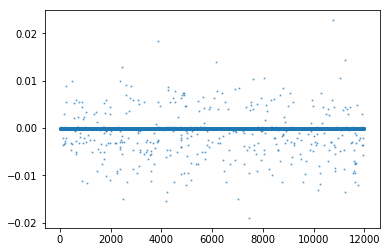

std(error) = 0.0010599097826
percent of errors less than 0.0005 (~5ns)= 0.990833333333


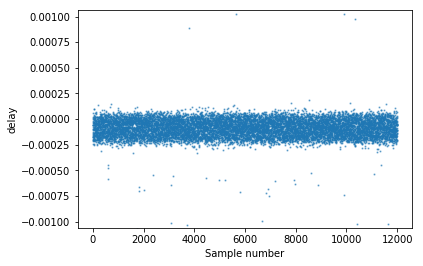

In [558]:
plt.plot(errors,
         ls = 'none',
         marker = 's', markersize = 1, alpha = 0.5)
plt.show()
print('std(error) = {}'.format(np.std(errors)))
print('percent of errors less than 0.0005 (~5ns)= {}'.format(np.mean(np.asarray(errors) < 0.0005)))
plt.xlabel('Sample number')
plt.ylabel('delay')
plt.plot(errors,
         ls = 'none',
         marker = 's', markersize = 1, alpha = 0.5)
plt.ylim(-np.std(errors),np.std(errors))
plt.xlabel('Sample number')
plt.ylabel('delay')
plt.show()

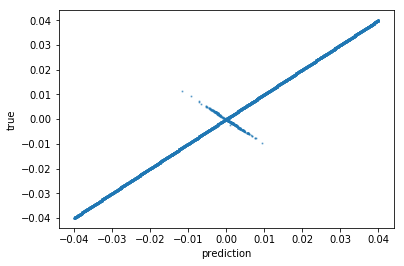

In [559]:
plt.plot(best_guesses, evaluation_targets, ls = 'none', marker = 's', markersize = 1, alpha = 0.5);
plt.xlabel('prediction')
plt.ylabel('true');

***

## Assuming these results are ok, can we solve Ax = b and get realistic results?

In [560]:
def make_A_from_list_o_sep_pairs(list_o_sep_pairs, max_ant): 
    def get_A_row(two_seps, max_ant_idx):
        """Contructs a row of A by placing a 1 or -1 in the index corresponding to an antenna"""

        a = two_seps.flatten()

        b = np.zeros((a.size, max_ant_idx), dtype = int)

        b[np.arange(a.size),a] = 1
        b[1] *= -1
        b[2] *= -1

        return np.sum(b, axis = 0)
    
    max_ant_idx = max_ant + 1
    A = []
    for two_seps in list_o_sep_pairs:
        
        A.append(get_A_row(two_seps, max_ant_idx = max_ant_idx))

    return np.asarray(A).reshape(-1, max_ant_idx)

In [561]:
# Find all the different antennas for this data set and extract the max value
unique_ants = []
for sep_pair in evaluation_seps:
    for sep in sep_pair:
        for ant in sep:
            if ant not in unique_ants:
                unique_ants.append(ant)
max_ant = np.max(unique_ants)       

In [562]:
# Create A
A = make_A_from_list_o_sep_pairs(evaluation_seps, max_ant )

### take a look at A.

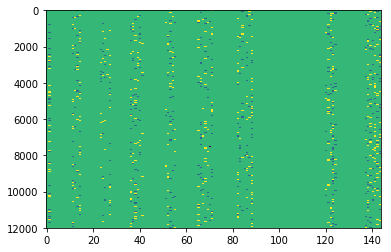

In [563]:
plt.imshow(A, aspect = 'auto');

Lots of blank columns because we are only usinga subset of the antennas.

Drop the missing antennas

In [564]:
# drop the empty columns ( the antennas not present)
A = A[:, unique_ants]

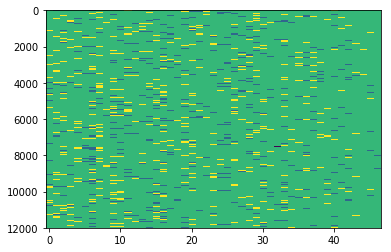

In [565]:
plt.imshow(A, aspect = 'auto');

In [566]:
# create b
b = np.array(best_guesses)

Solve Ax = b

In [567]:
# solve
x = np.linalg.lstsq(A, b, rcond=None)[0]

In [568]:
# suppress scientific notation
np.set_printoptions(suppress=True)

In [569]:
x

array([-0.00108469,  0.00013881, -0.0000018 , -0.00006002,  0.00150455,
        0.0004987 ,  0.00040099,  0.0003329 , -0.00061859,  0.00127149,
        0.00002589,  0.00015741, -0.0005538 , -0.00004211,  0.00109043,
       -0.000122  ,  0.00088413,  0.00140978, -0.00093906, -0.00031473,
       -0.00024083, -0.00093362,  0.00004078,  0.00240845,  0.00071855,
        0.00029563, -0.00006175, -0.00102093, -0.00054542, -0.00101743,
       -0.00071156, -0.00031165, -0.0000442 , -0.00066232, -0.00088489,
       -0.00126272, -0.0011763 ,  0.00010597,  0.00163523, -0.00034465,
       -0.00070276, -0.00127685,  0.00121248, -0.00160217,  0.00212811,
       -0.00085325,  0.00112982])

In [570]:
# convert to ~ns
x *10000

array([-10.84686095,   1.38813301,  -0.01796616,  -0.60022457,
        15.04550421,   4.98700373,   4.00988318,   3.32901117,
        -6.18592969,  12.71492656,   0.25885033,   1.57411963,
        -5.53798325,  -0.42112015,  10.90428993,  -1.22002955,
         8.84132754,  14.09779338,  -9.39055024,  -3.14734348,
        -2.40829108,  -9.33619947,   0.40779822,  24.08452478,
         7.18547722,   2.95627852,  -0.6174691 , -10.20933903,
        -5.45423212, -10.17432713,  -7.11555327,  -3.11651372,
        -0.44196848,  -6.62323168,  -8.848858  , -12.62716779,
       -11.76302608,   1.05965561,  16.35233287,  -3.44645871,
        -7.02764543, -12.76854134,  12.12475911, -16.021692  ,
        21.28113013,  -8.5324813 ,  11.29820466])

Should we weight AX = b? if so by what?

***
combined_prob as Weights 🤷🏻‍♂️

Solve wAx = wb

In [571]:
w = np.diag(combined_prob)

In [572]:
wb = np.dot(w,b)

In [573]:
wA = np.dot(w,A)

In [574]:
wx = np.linalg.lstsq(wA, wb, rcond=None)[0]

In [575]:
wx

array([-0.00101646,  0.000474  ,  0.00046127, -0.00065848,  0.00191913,
        0.00149873,  0.00055904,  0.00043446, -0.0009161 ,  0.00113359,
        0.00056495,  0.00060453, -0.00159902, -0.00002537,  0.00149523,
       -0.00000176,  0.00063912,  0.00224641, -0.00000458, -0.00058397,
       -0.00049651, -0.00086073,  0.00036288,  0.00293288,  0.00119953,
        0.00053293,  0.00003457, -0.00148106, -0.00068438, -0.00122221,
       -0.00111301, -0.00104394,  0.0001716 , -0.00084983, -0.00091353,
       -0.00135704, -0.0013039 , -0.00043559,  0.00164661,  0.00051915,
       -0.00086903, -0.00193029,  0.00105163, -0.00297003,  0.00279587,
       -0.00129889,  0.00035757])

In [576]:
wx*10000 # convert to ~ns

array([-10.1645652 ,   4.73995694,   4.61273078,  -6.58477819,
        19.19126117,  14.98727444,   5.59043752,   4.34464906,
        -9.16098496,  11.33589697,   5.6495318 ,   6.04529839,
       -15.99017798,  -0.25370759,  14.95233183,  -0.0176184 ,
         6.391232  ,  22.46413136,  -0.04581793,  -5.83973677,
        -4.96508735,  -8.6072652 ,   3.62884485,  29.32878649,
        11.99531499,   5.32929364,   0.34567981, -14.81062154,
        -6.84375834, -12.22211764, -11.13009917, -10.43942356,
         1.71597671,  -8.49833983,  -9.13526767, -13.57035273,
       -13.03904862,  -4.35587262,  16.46612943,   5.19150696,
        -8.6902997 , -19.30292709,  10.51631566, -29.70028386,
        27.95871237, -12.98885248,   3.57571126])

***
1/errors as Weights 🤷🏻‍♂️

Solve wAx = wb

In [593]:
we = np.diag(1/np.abs(errors))

In [594]:
web = np.dot(we,b)

In [595]:
weA = np.dot(we,A)

In [596]:
wex = np.linalg.lstsq(weA, web, rcond=None)[0]

In [597]:
wex

array([ 0.03345492, -0.00394584,  0.01899517,  0.01735146, -0.02809191,
       -0.02005322,  0.02298798, -0.00510302,  0.00655832, -0.00212924,
        0.0226316 , -0.0018143 , -0.01273362, -0.00737847, -0.00159308,
        0.01515722,  0.02248584, -0.00712102,  0.00013293,  0.02063212,
       -0.01211238,  0.01051498, -0.01625247, -0.01534629, -0.00908645,
       -0.0211797 ,  0.02804596, -0.03231591, -0.01985948, -0.02153107,
       -0.00779291,  0.01840216,  0.02936884, -0.01274332,  0.00244468,
       -0.00264158,  0.00821484, -0.01612738, -0.01835885,  0.0123358 ,
        0.00167599, -0.00451079,  0.01118639, -0.00804224, -0.00855361,
        0.00337979,  0.01046113])

In [598]:
wex*10000 # convert to ~ns

array([ 334.54921032,  -39.45842881,  189.9517493 ,  173.51463926,
       -280.91909077, -200.53219991,  229.87984322,  -51.0301614 ,
         65.58323029,  -21.29244369,  226.31604854,  -18.14299011,
       -127.33619116,  -73.78474984,  -15.93077924,  151.57221384,
        224.85838071,  -71.21017709,    1.32934949,  206.32121241,
       -121.12377804,  105.14977609, -162.5247024 , -153.46289325,
        -90.8644926 , -211.79704256,  280.45958454, -323.15910108,
       -198.5948193 , -215.31074667,  -77.92910955,  184.02164943,
        293.68841098, -127.43317317,   24.4467958 ,  -26.41580341,
         82.14839769, -161.27379801, -183.58853369,  123.35803055,
         16.75988257,  -45.10793003,  111.86394817,  -80.42238215,
        -85.53605656,   33.79794902,  104.61127225])

***
1/errors^0.5 as Weights 🤷🏻‍♂️

Solve wAx = wb

In [599]:
we2 = np.diag(1/np.abs(errors)**0.5)

In [600]:
we2b = np.dot(we2,b)

In [601]:
we2A = np.dot(we2,A)

In [602]:
we2x = np.linalg.lstsq(we2A, we2b, rcond=None)[0]

In [603]:
we2x

array([ 0.00624937, -0.00368851,  0.01037374,  0.00352684, -0.01316469,
       -0.0024842 ,  0.00699768, -0.00264991,  0.00130532, -0.00016592,
        0.00994404, -0.00304436, -0.01317171, -0.00749352, -0.00484669,
        0.00830226,  0.00681805,  0.00660414,  0.00474188,  0.01159637,
       -0.00454116,  0.01603861,  0.00434061, -0.01287327, -0.00713363,
       -0.00736771,  0.00851827, -0.01184782, -0.00748565, -0.0055094 ,
        0.00091734,  0.0066805 ,  0.01334137, -0.00308698,  0.00033377,
       -0.00574988, -0.00108147, -0.00506409, -0.00259609, -0.00308353,
        0.00296182,  0.00361431,  0.00239791, -0.0047635 , -0.00480062,
       -0.00515324,  0.00724338])

In [605]:
we2x*10000 # convert to ~ns

array([  62.49368147,  -36.88514251,  103.73741911,   35.26838157,
       -131.64689074,  -24.84202357,   69.9767624 ,  -26.49909997,
         13.05323452,   -1.6591994 ,   99.44037791,  -30.44364148,
       -131.71705012,  -74.93520729,  -48.46689706,   83.02255578,
         68.18051586,   66.04144012,   47.41875139,  115.9636625 ,
        -45.41159078,  160.3860556 ,   43.40608893, -128.73270373,
        -71.33625336,  -73.67714909,   85.18265426, -118.47823649,
        -74.85646643,  -55.0939622 ,    9.1734186 ,   66.80496599,
        133.41368885,  -30.86977095,    3.33773986,  -57.49884944,
        -10.81467941,  -50.64090189,  -25.96092719,  -30.83532247,
         29.61818929,   36.14314643,   23.97909686,  -47.63499916,
        -48.00622457,  -51.53238832,   72.43375033])